In [1]:
%%capture
%%bash
cd ../..
pip install -U pip
pip install -e .

# Single and Multi-Armed Bandits Lab

The lab for this week for Reinforcement Learning - Regis University - MSDS 684, is an introduction to the bandit problem. I have split this lab into two sections. The first is an exploration of the bandit problem using the python package that I have written here [reinforcement-learning-gym](https://github.com/tosterberg/reinforcement-learning-gym.git). Which was written for me to better explore the problem and create a consistent way of interacting with the problems found in Reinforcement Learning: An Introduction (Sutton & Barto, 2018). Hopefully, it will be extensible enough that it can be used in the upcoming labs. The second section of the lab will be analysis and experimentation of the provided notebook examples from the class. These cover single and multi-armed bandit problems, with their own implementations.



## Python Package Design - Algorithm Implementations
The readings and lab notebooks handed out in class together highlight the bandit problem, and greedy or ε-greedy algorithms. With reinforcement learning problems being a solution to an agent interacting with an environment, estimating the rewards for given actions, and using a policy to determine those actions I have set up the project using the same discrete components. A scenario will be the portion of the problem that determines what actions are available and what reward is given for an action (this could be renamed environment in the future but for now the environment is all components of an experiment). The agent contains a policy which it uses for determining an action, as well as the memory of its past rewards, available action, actions taken, and estimates for the rewards of given actions. The policy is the specific algorithm used for determining an action, and so far there are implementations for greedy, ε-greedy, optimistic initial values greedy, and random. The environment takes a configuration, an agent and a scenario and outputs the results of the experiment. Next we will begin experimenting with this implementation and discussing the results.


### ε-greedy - Algorithm
We will begin our experimentation with the ε-greedy implementation in our python package. We will explore the upper and lower bounds (greedy, random), and the trends observed in this kind of learning.

In [2]:
from reinforce.scenarios.bandit import Bandit
from reinforce.agents.agent import Agent
from reinforce.policies.policy import GreedyPolicy, EpsilonGreedyPolicy, RandomPolicy
from reinforce.environments.environment import Environment
from reinforce.utils.utils import plot_env_result

In [3]:
k_arms = 10
steps = 2000
runs = 100

scenario = Bandit(arms=k_arms, mean=0, std=1)
results = []

# Test epsilon-greedy 0 -> completely greedy 1 -> completely random
eps = [0, 0.01, 0.1, 0.2, 1]
for epsilon in eps:
    agent = Agent(num_actions=k_arms, policy=EpsilonGreedyPolicy(epsilon=epsilon))
    environment = Environment(scenario=scenario, agent=agent, steps=steps, iterations=runs)
    environment.summarize_test()
    results.append(environment.results)

EpsilonGreedy: 0.00, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=2000, iterations=100
Total reward: 109,157.73
Mean reward per step: 0.5458

EpsilonGreedy: 0.01, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=2000, iterations=100
Total reward: 121,986.68
Mean reward per step: 0.6099

EpsilonGreedy: 0.10, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=2000, iterations=100
Total reward: 131,681.83
Mean reward per step: 0.6584

EpsilonGreedy: 0.20, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=2000, iterations=100
Total reward: 122,667.88
Mean reward per step: 0.6133

EpsilonGreedy: 1.00, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=2000, iterations=100
Total reward: 5,206.05
Mean reward per step: 0.0260



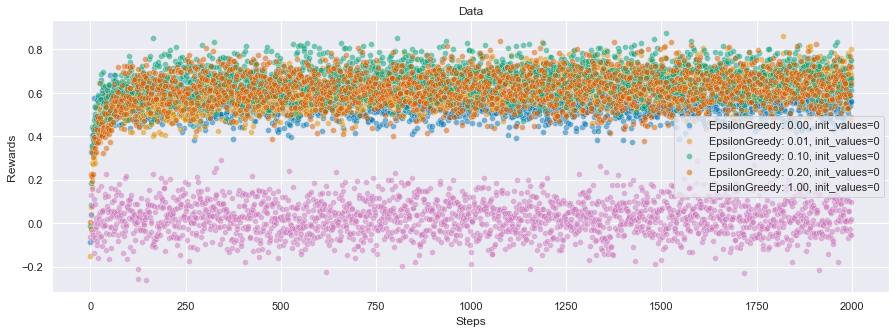

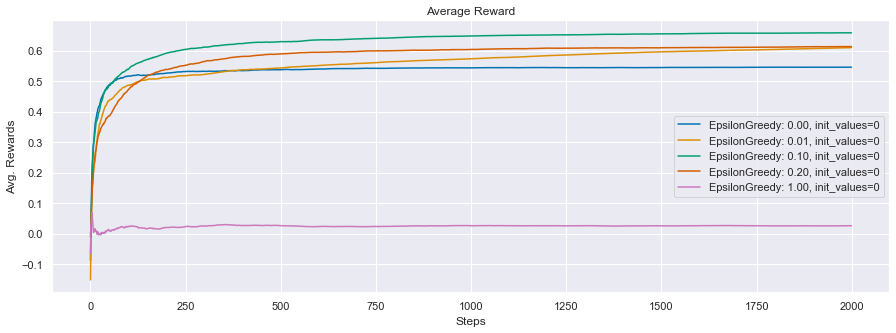

In [4]:
plot_env_result(results)

I think it is important to discuss how are bandit scenario was written before we interpret the results. The way that my version was implemented we pick a number of arms and then randomly choose on a normal distribution what their mean reward will be. When an action is taken the mean reward acts as the center-point for another normal distribution that randomly assigns the reward on any given action. This means that our effective upper and lower bounds are +3 and -3 for mean reward. This is also the average over 100 iterations so the likelihood of extreme values trends toward a normal distribution.

What we observe is that our random choice policy is trending towards zero, which makes sense given the above implementation that we are working with. The exploration coefficient of around 0.1 appears to be our best maximizer for reward given this many learning steps, although it appears that our lower learning rate 0.01 will perform better given a larger time horizon. Which we will test next.

In [5]:
k_arms = 10
steps = 12000
runs = 100

scenario = Bandit(arms=k_arms, mean=0, std=1)
results = []

# Test epsilon-greedy best performers
eps = [0.01, 0.05, 0.1]
for epsilon in eps:
    agent = Agent(num_actions=k_arms, policy=EpsilonGreedyPolicy(epsilon=epsilon))
    environment = Environment(scenario=scenario, agent=agent, steps=steps, iterations=runs)
    environment.summarize_test()
    results.append(environment.results)


EpsilonGreedy: 0.01, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=12000, iterations=100
Total reward: 927,338.49
Mean reward per step: 0.7728

EpsilonGreedy: 0.05, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=12000, iterations=100
Total reward: 938,886.96
Mean reward per step: 0.7824

EpsilonGreedy: 0.10, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=12000, iterations=100
Total reward: 879,550.89
Mean reward per step: 0.7330



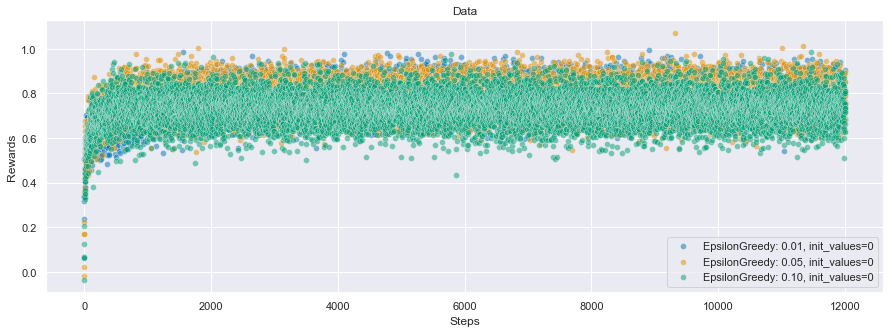

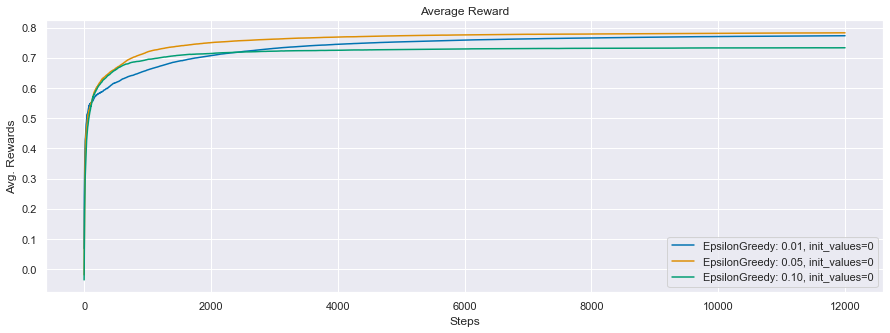

In [6]:
plot_env_result(results)

It does appear that our ε-greedy with less exploration does have a higher maximum average reward when given enough learning steps. This gives us insight into a future improvement on the algorithm where ε would rather than being a constant be a function ε(t) where as t increase the exploration coefficient decreases.

### greedy - Algorithm
Our next algorithm to explore is the pure greedy algorithm. In its initial implementation of our GreedyPolicy our agent has all actions estimated as zero, and will pull each arm once before applying the greedy algorithm to its action choice. This is done because if the first pulls reward is above zero it will only continue pulling that lever unless the estimated reward eventually drops below zero which could cause for some very low local maxima. However, we did implement a way for agents to initialize their own reward estimates before starting. This provides two other experiments to run. The first is what was outlined above where we don't do the initial exploration, and another where we initialize to overly optimistic values in order to encourage some exploration. Setting up the agents as outlined above we are ready for our greedy algorithm experiments.

In [7]:
k_arms = 10
steps = 2000
runs = 100

scenario = Bandit(arms=k_arms, mean=0, std=1)
results = []

# Test alternative greedy
agents = [
    Agent(num_actions=k_arms, policy=GreedyPolicy()),
    Agent(num_actions=k_arms, policy=GreedyPolicy(initialized=True)),
    Agent(num_actions=k_arms, policy=GreedyPolicy(), init_value=5)
]
for agent in agents:
    environment = Environment(scenario=scenario, agent=agent, steps=steps, iterations=runs)
    environment.summarize_test()
    results.append(environment.results)

Greedy: Agent initialized, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=2000, iterations=100
Total reward: 96,121.70
Mean reward per step: 0.4806

Greedy: Pull once, init_values=0
Bandit: arms=10, mean=0, std=1
Environment: steps=2000, iterations=100
Total reward: 113,831.83
Mean reward per step: 0.5692

Greedy: Agent initialized, init_values=5
Bandit: arms=10, mean=0, std=1
Environment: steps=2000, iterations=100
Total reward: 142,759.94
Mean reward per step: 0.7138



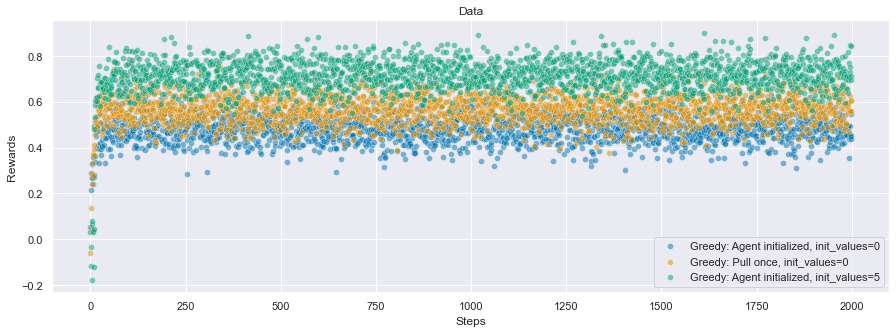

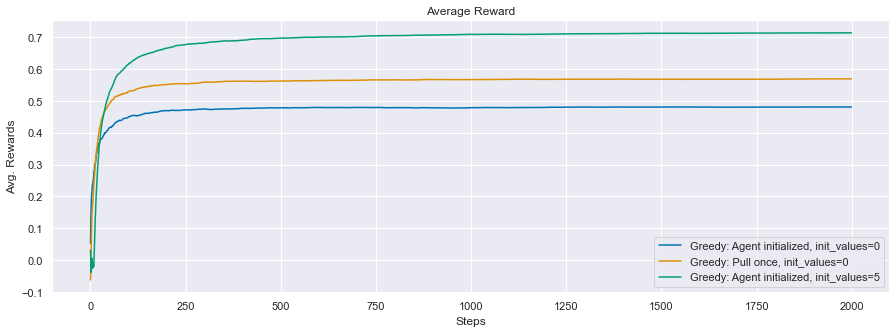

In [8]:
plot_env_result(results)

Here we can observe that our Greedy agent initialized at zero appears to be equivalent to running the ε-greedy with ε=0. It is also the worst of our greedy algorithms, with initial exploration doing better, and optimistic estimates doing the best. The optimistic estimates greedy agent actually did this best of our algorithms in a 2000-step timeframe.

## Lab Supplied Algorithms
Stuff about it

### Single Armed Bandit


In [9]:
from reinforce.experiments.one_armed_bandit import run_experiment
import random

In [10]:
# All code  in the Lab Supplied section is from https://github.com/doug57/MSDS684_1
seed = None
N = 1000
mu = 0
sigma = 10

In [12]:
run_experiment(mu, sigma, N)

NameError: name 'random' is not defined

### Multi-armed Bandit


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

from reinforce.scenarios.bandit import ProvidedBandit


In [ ]:
N = 10000
eps = 0.25
num_bandits = 3

mean = [] # mean of each bandit
variance = [] # variance of each bandit
sample_variance = [] # sample variance of each bandit

Bandits = [] # list of bandit objects
mu = [10,5,1] # mean of each bandit
sigma = [1,1,1] # sdev of each bandit


In [ ]:

for i in range(num_bandits):
    Bandits.append(ProvidedBandit(mu[i], sigma[i])) # create bandit objects

rewards = [] # list of rewards from the bandits

for i in range(num_bandits):
    Bandits[i].xn = Bandits[i].play()
    rewards.append(Bandits[i].xn)
    Bandits[i].mean = Bandits[i].xn
    mean.append(Bandits[i].xn)

for i in range(num_bandits,N):
    # do epsilon greedy
    val = random.random()  # returns random number in [0.0, 1.0)
    if val < eps:
        bandit_choice = random.choice([i for i in range(num_bandits)])
        x = Bandits[bandit_choice].play()
        rewards.append(x)
        mean[bandit_choice] = Bandits[bandit_choice].get_statistics()[0]
        #print(f'x: {x:.2f},bandit_choice: {bandit_choice},mean[bandit_choice]: {mean[bandit_choice]:.2f}')
    else:
        max_index = 0 # find index of the bandit with the highest mean
        max_value = Bandits[0].mean
        for j in range(1,num_bandits):
            if Bandits[j].mean > max_value:
                max_value = Bandits[j].mean
                max_index = j
        x = Bandits[max_index].play()
        rewards.append(x)
        mean[max_index] = Bandits[max_index].get_statistics()[0]
        #print(f'x: {x:.2f},bandit_max: {max_index},mean[max_index]: {mean[max_index]:.2f}')


In [ ]:

summed_rewards = [rewards[0]]
for i in range(1,len(rewards)):
    summed_rewards.append(rewards[i] + summed_rewards[i-1])

average_rewards = []
for i in range(0,len(rewards)):
    average_rewards.append(summed_rewards[i]/(i+1))


In [ ]:

print("Bandit 0 - pulled", Bandits[0].n, "times. Estimated mean -", Bandits[0].mean)
print("Bandit 1 - pulled", Bandits[1].n, "times. Estimated mean -", Bandits[1].mean)
print("Bandit 2 - pulled", Bandits[2].n, "times. Estimated mean -", Bandits[2].mean)
print("Total reward   - ", summed_rewards[N - 1])
print("Average reward - ", average_rewards[N - 1])


In [ ]:

# plots using seaborn
def multi_bandit_plots(count, data, averagereward):
    description = {"iteration": count, "value": data, "average reward": averagereward}
    pddata = pd.DataFrame(description)

    plt.rcParams["figure.figsize"] = [15, 5]

    sns.set(style="darkgrid")
    ax1 = sns.scatterplot(x="iteration", y="value", data=pddata)
    ax1.set(xscale="linear", yscale="linear")
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.set_title("Data")

    plt.show()

    sns.set(style="darkgrid")
    ax2 = sns.lineplot(x="iteration", y="average reward", data=pddata)
    ax2.set(xscale="linear", yscale="linear")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.set_title("Average Reward")

    plt.show()


In [ ]:

count = [x for x in range(len(rewards))]
multi_bandit_plots(count, rewards, average_rewards)


# References

Sutton, R. S., & Barto, A. G. (2018). *Reinforcement learning: An introduction* (Second edition). The MIT Press.